In [1]:
import pandas as pd
import numpy as np
import os

os.getcwd()

'C:\\Users\\hruia\\PycharmProjects\\camelot-icml\\src\\analysis'

In [3]:
# Get labels
y_true = pd.read_csv("../../results/MIMIC/CAMELOT/run21/y_true.csv", index_col=0, header=0)
y_pred = pd.read_csv("../../results/MIMIC/CAMELOT/run21/y_pred.csv", index_col=0, header=0)

In [10]:

def _get_cm_values(has_label_true: np.ndarray, has_label_pred: np.ndarray) -> dict:
    """
    Get dictionary of TP, FN, FP, TN values given a binary label indicator and a vector of binary predictions.

    Params:
    - has_label_true: np.ndarray of shape (N, ) with {0, 1} entries.
    - has_label_pred: np.ndarray of shape (N, ) with {0, 1} entries.
    
    Returns:
    - Dictionary of True/False Positives/Negatives
    """
    
    # Both equal to 1 for true positives
    tp = ((has_label_true==1) & (has_label_pred==1)).sum()

    # True=1, False=0 for false negatives
    fn = ((has_label_true==1) & (has_label_pred==0)).sum()

    # True=0, False=1 for false positives
    fp = ((has_label_true==0) & (has_label_pred==1)).sum()

    # True=0, False=0 for true negatives
    tn = ((has_label_true==0) & (has_label_pred==0)).sum()

    # Return dictionary
    return {"tp": tp, "fn": fn, "fp": fp, "tn": tn}


def _custom_cm_over_threshold(y_true: np.ndarray, y_score: np.ndarray) -> tuple:
    """
    Compute True/False Positive/Negatives of multi-class predictions y_true, y_score with a commonly variying threshold.

    Params:
    - y_true: np.ndarray of shape (N, num_outcs) with one-hot encoded true label encodings.
    - y_score: np.ndarray of shape (N, num_outcs) with predicted probability outcome assignments.

    Returns:
        Tuple (threshold, TP, FN, FP, TN) of T/F P/N values for a common threshold list.
    """
    # Compute varying thresholds
    _min, _max = np.min(y_score), np.max(y_score)
    thresholds = np.linspace(start=_min, stop=_max, num=100000, endpoint=True)

    # Initialise output variables
    shape = (100000, y_true.shape[-1])
    tp, fn, fp, tn = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)

    # Iterate over thresholds
    for thresh_id, eps in enumerate(thresholds):

        # Convert scores to binary
        y_pred_thresh = (y_score >= eps).astype(int)

        # Iterate over outcomes
        for outc_id in range(y_true.shape[-1]):

            # Get conf matrix values
            conf_matrix = _get_cm_values(y_true[:, outc_id], y_pred_thresh[:, outc_id])

            # Update scores
            tp[thresh_id, outc_id] = conf_matrix["tp"]
            fn[thresh_id, outc_id] = conf_matrix["fn"]
            fp[thresh_id, outc_id] = conf_matrix["fp"]
            tn[thresh_id, outc_id] = conf_matrix["tn"]

    return thresholds, tp, fn, fp, tn


def _get_cm_metrics(y_true, y_score):
    
    threshs, tp, fn, fp, tn = _custom_cm_over_threshold(y_true, y_score)
    
    # Get sensitivity and specificity
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    # Get precision and recall
    precision = tp / (tp + fp)
    precision[np.isnan(precision)] = 1
    recall = tp / (tp + fn)
    
def custom_auc(y_true: np.ndarray, y_score: np.ndarray) -> np.ndarray:
    """
    Compute Custom Area-under-the-receiver-curve on multi-class setting. The score is computed as regular AUROC, except that the thresholds per each class
    are not allowed to vary independently. 

    For each threshold, labels with value higher than epsilon are flagged up, consequently AUROC per each class is computed. Area under the curve is consequently
    computed as regular.

    Params:
    - y_true: np.ndarray of shape (N, num_outcs) with one-hot encoded true label encodings.
    - y_score: np.ndarray of shape (N, num_outcs) with predicted probability outcome assignments.

    Returns:
        area: np.array of dimension (y_score.shape[-1], ) with corresponding area eestimations.
    """
    _ , tp, fn, fp, tn = _custom_cm_over_threshold(y_true=y_true, y_score=y_score)

    # Compute Sensitivity and Specificity
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    # Ensure fpr always non-increasing
    assert np.all(np.diff(fpr[1:, :],axis=0) <= 0, axis=None)

    # Compute area under curve with trapezoidal rule - multiply by -1 as fpr is decreasing
    area = - np.trapz(y=tpr, x=fpr, axis=0)

    return area
    

def custom_prc(y_true: np.ndarray, y_score: np.ndarray) -> np.ndarray:
    """
    Compute custom area-under-the-precision-recall curve on multi-class setting. The score is computed as regular AUPRC, except thresholds per each class
    are not allowed to vary independently, and apply to each class simultaneously.
    
    Params:
    - y_true: np.ndarray of shape (N, num_outcs) with one-hot encoded true label encodings.
    - y_score: np.ndarray of shape (N, num_outcs) with predicted probability outcome assignments.

    Returns:
        area: np.array of dimension (y_score.shape[-1], ) with corresponding area eestimations.
    
    """
    _ , tp, fn, fp, tn = _custom_cm_over_threshold(y_true=y_true, y_score=y_score)

    # Compute Precision and recall
    precision = np.divide(tp ,tp + fp, out=np.zeros_like(tp), where=tp+fp==0)
    recall = tp / (tp + fn)

    # Ensure always decreasing
    assert np.all(np.diff(recall, axis=0) <= 0, axis=None)

    # Compute Area under curve - need to multiply by -1 as recall is decreasing (and not increasing)
    area = - np.trapz(y=precision, x=recall, axis=0)

    return area


In [20]:
threshs, tp, fn, fp, tn = _custom_cm_over_threshold(y_true=y_true.values, y_score=y_pred.values)

# Get sensitivity specificity, precision and recall
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
precision[np.isnan(precision)] = 1
recall = tp / (tp + fn)

C:\Users\hruia\AppData\Local\Temp\ipykernel_17404\3625994819.py:6: RuntimeWarning: invalid value encountered in true_divide
  precision = tp / (tp + fp)


In [37]:
np.all(np.diff(precision, axis=0)[1:, :])

False

De    0.004893
I     0.169364
W     0.705307
Di    0.120437
dtype: float64

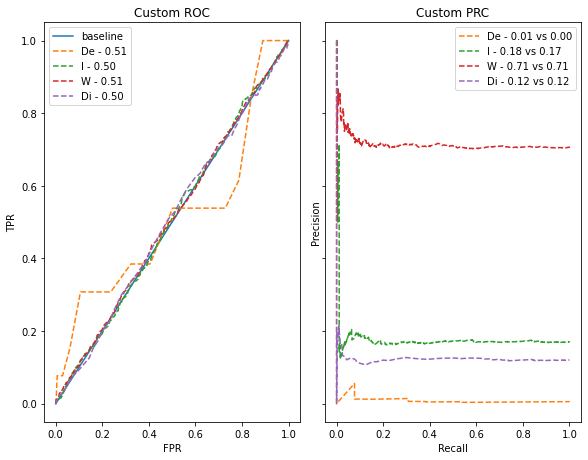

In [53]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

colors = get_cmap("tab10").colors

outcs, num_outcs = y_true.columns.tolist(), y_true.shape[-1]

# Get fig, ax
fig, ax = plt.subplots(nrows=1, ncols=2, sharex="all", sharey="all", figsize=(8.27, 6.5))
baseline_roc = np.linspace(0, 1, num=1000)
baseline_prc = np.repeat(precision[0, :].reshape(1, -1), repeats=1000, axis=0)
ax[0].plot(baseline_roc, baseline_roc, linestyle="-", color=colors[0], label="baseline")

# Iterate over axes
for outc_id, outc in enumerate(outcs):
    
    # Plot AUROC and compute auroc
    auc = np.trapz(tpr[::-1, outc_id], fpr[::-1, outc_id])
    ax[0].plot(fpr[::-1, outc_id], tpr[::-1, outc_id], linestyle="--", color=colors[outc_id+1], label=f"{outc} - {auc:.2f}")
    
    # PLOT AUPRC
    prc = np.trapz(precision[::-1, outc_id], recall[::-1, outc_id])
    ax[1].plot(recall[::-1, outc_id], precision[::-1, outc_id], linestyle="--", color=colors[outc_id+1], label=f"{outc} - {prc:.2f} vs {baseline_prc[0, outc_id]:.2f}")
    
    # Add labels
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].set_title(f"Custom PRC")
    ax[1].legend()
    
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[0].set_title(f"Custom ROC")
    ax[0].legend()
    
plt.tight_layout()
plt.show()